So the data is gathered from trading view and added to use as a analysis point

Data of 15min charts is used for alert signs and the data of 1min charts is used to check accurate Target profit points and stop loss points.

Will ignore all datasets for privacy.


In [10]:
import pandas as pd

# Load the CSV files
minute_data_c23400 = pd.read_csv(r'June 2024\NIFTY\20240620\NSE_NIFTY240620C23400, 1.csv')
minute_data_15_c23400 = pd.read_csv(r'June 2024\NIFTY\20240620\NSE_NIFTY240620C23400, 15.csv')

# Filter buy signals
def filter_signals(data):
    buy_signals = data[(data['Original Buy Signal'] == True) & (data['Short Signal'] == False)]
    return buy_signals

buy_signals = filter_signals(minute_data_15_c23400)

# Simulate trades
def simulate_trades(buy_signals, minute_data, profit_target=0.02, stop_loss=0.01, min_stop_loss=0.005):
    results = []
    for index, buy_signal in buy_signals.iterrows():
        entry_price = buy_signal['close']
        entry_time = buy_signal['time'] + 900 # Add 15 minutes to the buy signal time to get the entry time
        profit_price = entry_price * (1 + profit_target)
        stop_price = entry_price * (1 - max(stop_loss, min_stop_loss))  # Ensure stop loss is at least min_stop_loss
        
        trade_result = {
            'entry_time': entry_time,
            'entry_price': entry_price,
            'exit_time': None,
            'exit_price': None,
            'profit': None
        }
        
        subsequent_data = minute_data[minute_data['time'] > entry_time]
        for _, row in subsequent_data.iterrows():
            if row['high'] >= profit_price:
                trade_result['exit_time'] = row['time']
                trade_result['exit_price'] = profit_price
                trade_result['profit'] = profit_price - entry_price
                break
            if row['low'] <= stop_price:
                trade_result['exit_time'] = row['time']
                trade_result['exit_price'] = stop_price
                trade_result['profit'] = stop_price - entry_price
                break
        
        results.append(trade_result)
    
    return pd.DataFrame(results)



Analye the results now

In [13]:

# Analyze different profit and stop loss percentages
def analyze_profit_and_stop_loss(buy_signals, minute_data, profit_percentages, stop_loss_percentages, min_stop_loss=0.005):
    analysis_results = []
    finalresults = []
    for profit_target in profit_percentages:
        for stop_loss in stop_loss_percentages:
            trade_results = simulate_trades(buy_signals, minute_data, profit_target, stop_loss, min_stop_loss)
            total_profit = trade_results['profit'].sum()
            analysis_results.append((profit_target, stop_loss, total_profit))
            finalresults.append(trade_results)
        # Combine all trade results into a single DataFrame
    combined_trade_results = pd.concat(finalresults, ignore_index=True)
    combined_trade_results.to_csv(r'Outputs/NIFTY/NSE_NIFTY240620C23400_trade_results.csv', index=False)
    
    return pd.DataFrame(analysis_results, columns=['Profit Target', 'Stop Loss', 'Total Profit'])


# Define profit percentages and stop loss percentages to analyze
profit_percentages = [i/100 for i in range(1, 200)]
stop_loss_percentages = [i/100 for i in range(1, 30)]

# Perform the analysis
analysis_results = analyze_profit_and_stop_loss(buy_signals, minute_data_c23400, profit_percentages, stop_loss_percentages)
print(analysis_results)

C:\temp\ipykernel_7756\159350974.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_trade_results = pd.concat(finalresults, ignore_index=True)


      Profit Target  Stop Loss  Total Profit
0              0.01       0.01       -2.2865
1              0.01       0.02      -10.6075
2              0.01       0.03      -18.9285
3              0.01       0.04      -27.2495
4              0.01       0.05      -35.5705
...             ...        ...           ...
9746           1.99       0.45      -91.1250
9747           1.99       0.46      -93.1500
9748           1.99       0.47      -95.1750
9749           1.99       0.48      -97.2000
9750           1.99       0.49        0.0000

[9751 rows x 3 columns]


Store them as CSV and printout for visulaisation

In [14]:
# Save the results to a CSV file
analysis_results.to_csv('Outputs/NIFTY/NSE_NIFTY240620C23400_pnl_analysis.csv', index=False)

Create a heatmap maybe?.


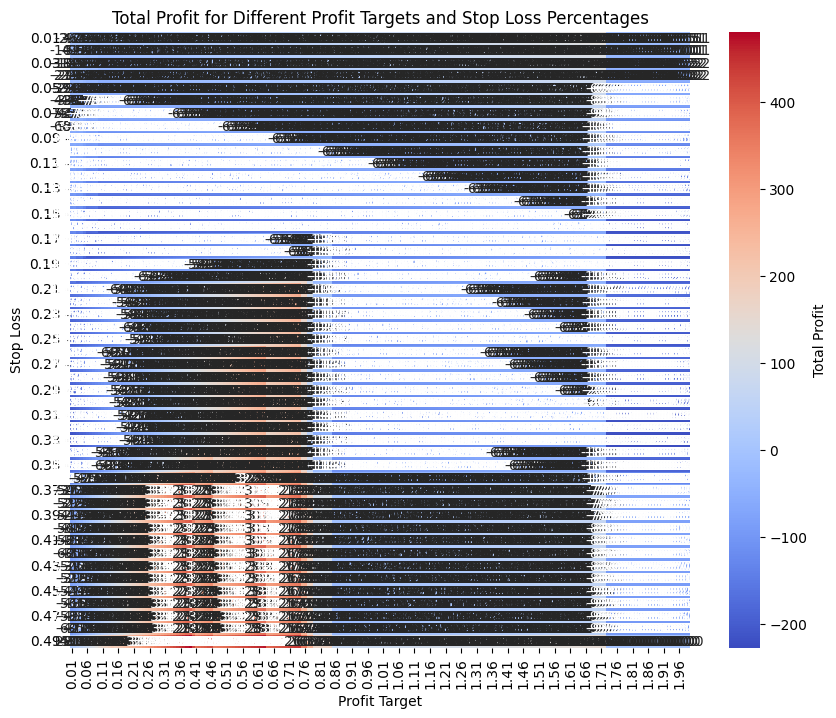

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the analysis results
analysis_results = pd.read_csv('Outputs/NIFTY/NSE_NIFTY240620C23400_pnl_analysis.csv')

# Pivot the data for heatmap
pivot_table = analysis_results.pivot(index="Stop Loss", columns="Profit Target", values="Total Profit")

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Total Profit'})
plt.title("Total Profit for Different Profit Targets and Stop Loss Percentages")
plt.xlabel("Profit Target")
plt.ylabel("Stop Loss")
plt.show()


Try something similar for trade results?.


C:\Users\MSI PC\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


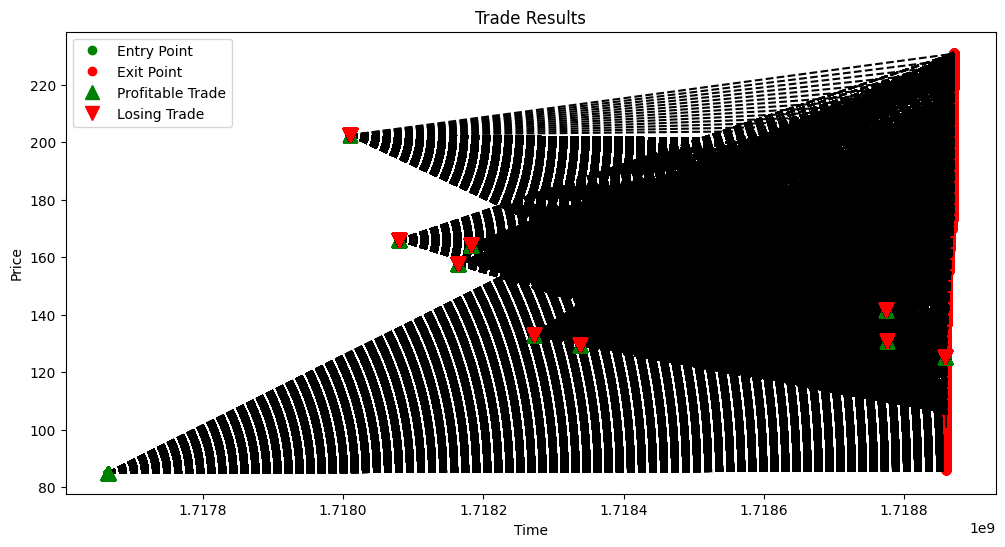

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the trade results
trade_results = pd.read_csv('Outputs/NIFTY/NSE_NIFTY240620C23400_trade_results.csv')

# Plot the trade results
plt.figure(figsize=(12, 6))

# Plot entry and exit points
plt.plot(trade_results['entry_time'], trade_results['entry_price'], 'go', label='Entry Point')
plt.plot(trade_results['exit_time'], trade_results['exit_price'], 'ro', label='Exit Point')

# Connect entry and exit points with lines
for i in range(len(trade_results)):
    plt.plot([trade_results['entry_time'][i], trade_results['exit_time'][i]], 
             [trade_results['entry_price'][i], trade_results['exit_price'][i]], 'k--')

# Highlight profitable and losing trades
profit_trades = trade_results[trade_results['profit'] > 0]
loss_trades = trade_results[trade_results['profit'] <= 0]

plt.plot(profit_trades['entry_time'], profit_trades['entry_price'], 'g^', markersize=10, label='Profitable Trade')
plt.plot(loss_trades['entry_time'], loss_trades['entry_price'], 'rv', markersize=10, label='Losing Trade')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Trade Results')
plt.legend()
plt.show()


Check Best Profit and Stop loss percentage combination

Best Profit Target Percentage: 39.00%
Best Stop Loss Percentage: 49.00%
Total Profit: 480.89


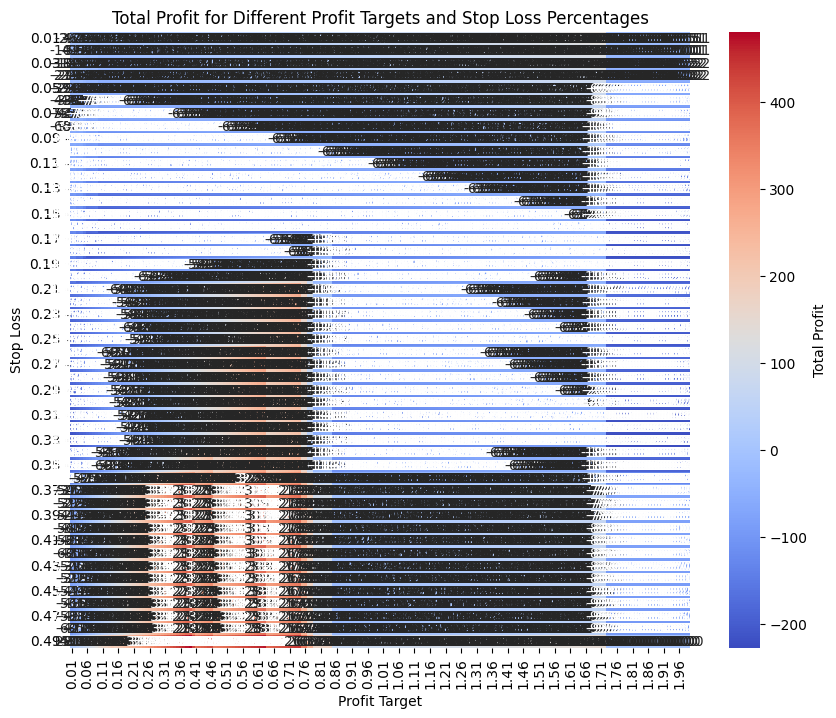

In [24]:
import pandas as pd

# Load the analysis results
analysis_results = pd.read_csv('Outputs/NIFTY/NSE_NIFTY240620C23400_pnl_analysis.csv')

# Find the best combination of profit target and stop loss
best_combination = analysis_results.loc[analysis_results['Total Profit'].idxmax()]

# Print the best combination
print("Best Profit Target Percentage: {:.2f}%".format(best_combination['Profit Target'] * 100))
print("Best Stop Loss Percentage: {:.2f}%".format(best_combination['Stop Loss'] * 100))
print("Total Profit: {:.2f}".format(best_combination['Total Profit']))

# Plot the heatmap for better visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the data for heatmap
pivot_table = analysis_results.pivot(index="Stop Loss", columns="Profit Target", values="Total Profit")

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Total Profit'})
plt.title("Total Profit for Different Profit Targets and Stop Loss Percentages")
plt.xlabel("Profit Target")
plt.ylabel("Stop Loss")
plt.show()


Saving Best profit and stop loss percentages


In [26]:
best_pnl=pd.read_csv('Outputs/NIFTY/bestpnl.csv')
best_pnl.append(best_combination['Profit Target'],best_combination['Stop Loss'],best_combination['Total Profit'])
best_pnl.to_csv('Outputs/NIFTY/bestpnl.csv', index=False)

EmptyDataError: No columns to parse from file